# Chelsea Jaculina
# DATA 266 HW 2 Q3

Step 1: Install Libraries

In [1]:
!pip install -q datasets sentence-transformers tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Step 2: Load the Dataset

In [33]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("AlekseyKorshuk/quora-question-pairs")

# Subset and shuffle
full_data = dataset["train"].shuffle(seed=42).select(range(50000))

# Use Hugging Face's train_test_split
split_dataset = full_data.train_test_split(test_size=0.2, seed=42)
train_split = split_dataset['train']
test_split = split_dataset['test']

Step 3: Generate Embeddings Using Pre-trained Model

In [46]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Encode training questions
q1_train = embedder.encode(train_split['question1'], convert_to_tensor=True)
q2_train = embedder.encode(train_split['question2'], convert_to_tensor=True)
labels_train = train_split['is_duplicate']

# Encode test questions
q1_test = embedder.encode(test_split['question1'], convert_to_tensor=True)
q2_test = embedder.encode(test_split['question2'], convert_to_tensor=True)
labels_test = test_split['is_duplicate']

Step 4: Prepare TensorFlow Dataset

In [17]:
import tensorflow as tf

def create_tf_dataset(q1_emb, q2_emb, labels):
    return tf.data.Dataset.from_tensor_slices(((q1_emb, q2_emb), labels))

# Create train and test datasets
train_ds = create_tf_dataset(q1_train, q2_train, labels_train).shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = create_tf_dataset(q1_test, q2_test, labels_test).batch(64)

Step 5: Define Siamese Model with Contrastive Loss

In [39]:
from tensorflow.keras import layers, Model, Input
import tensorflow as tf

# Custom Cosine Similarity Layer
class CosineSimilarityLayer(layers.Layer):
    def call(self, inputs):
        x1, x2 = inputs
        x1 = tf.math.l2_normalize(x1, axis=1)
        x2 = tf.math.l2_normalize(x2, axis=1)
        return 1 - tf.reduce_sum(x1 * x2, axis=1, keepdims=True)

# Contrastive Loss Function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return tf.reduce_mean((1 - y_true) * tf.square(y_pred) +
                          y_true * tf.square(tf.maximum(margin - y_pred, 0)))

# Build Siamese Network using Cosine Similarity
def build_siamese_network(input_dim):
    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))
    distance = CosineSimilarityLayer()([input_a, input_b])
    model = Model(inputs=[input_a, input_b], outputs=distance)
    return model

# Instantiate and compile the model
siamese_model = build_siamese_network(384)  # assuming MiniLM embeddings
siamese_model.compile(optimizer='adam', loss=contrastive_loss, metrics=['accuracy'])

 Step 6: Train the Model

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = siamese_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4044 - loss: 0.4515 - val_accuracy: 0.5788 - val_loss: 0.2589
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4117 - loss: 0.4460 - val_accuracy: 0.5788 - val_loss: 0.2589
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4097 - loss: 0.4449 - val_accuracy: 0.5788 - val_loss: 0.2589
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4097 - loss: 0.4496 - val_accuracy: 0.5788 - val_loss: 0.2589
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4145 - loss: 0.4420 - val_accuracy: 0.5788 - val_loss: 0.2589
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4060 - loss: 0.4484 - val_accuracy: 0.5788 - val_loss: 0.2589
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4142 - loss: 0.4456 - val_accuracy: 0.5788 - val_loss: 0.2589
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4110 - loss: 0.4437 - val_accuracy: 0.

Step 7: Plot Learning Curves

🔁 Building metrics DataFrame from training history...
✅ Metrics DataFrame created.
   Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
0      1        0.410625              0.57875    0.446209         0.258906
1      2        0.410625              0.57875    0.446209         0.258906
2      3        0.410625              0.57875    0.446209         0.258906
3      4        0.410625              0.57875    0.446209         0.258906
4      5        0.410625              0.57875    0.446209         0.258906
✅ Saved CSV to training_metrics.csv
✅ Saved Excel to training_metrics.xlsx


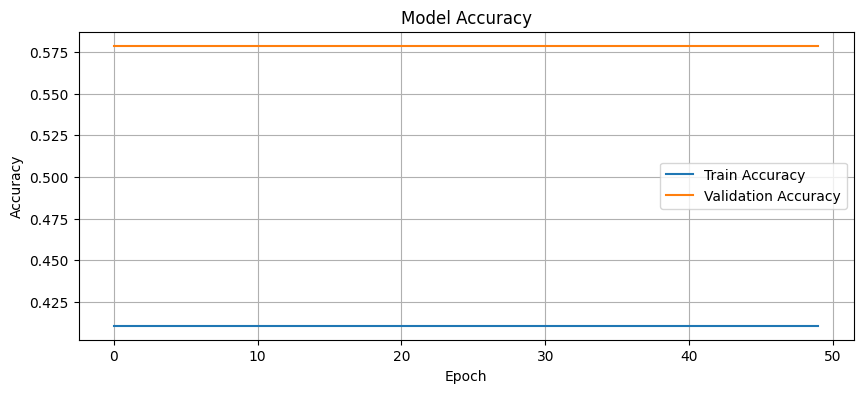

✅ Saved accuracy plot to accuracy_plot.png


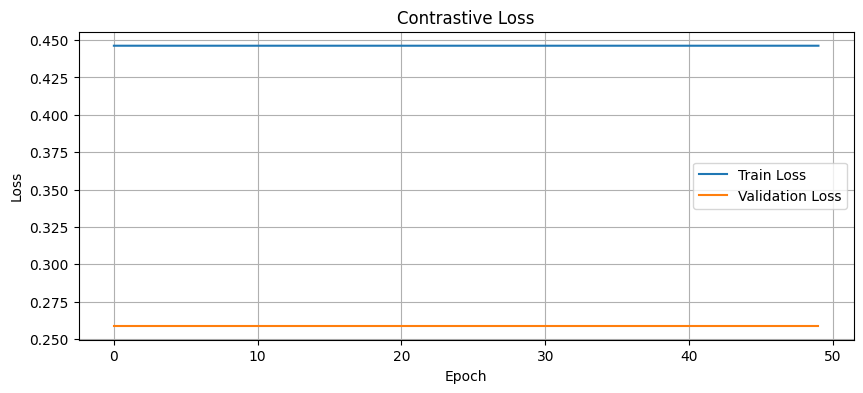

✅ Saved loss plot to loss_plot.png
✅ Embedded plots into Excel file: training_metrics.xlsx
📋 Final Training & Validation Metrics Table:


,Epoch,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,1,0.4106,0.5788,0.4462,0.2589
1,2,0.4106,0.5788,0.4462,0.2589
2,3,0.4106,0.5788,0.4462,0.2589
3,4,0.4106,0.5788,0.4462,0.2589
4,5,0.4106,0.5788,0.4462,0.2589
5,6,0.4106,0.5788,0.4462,0.2589
6,7,0.4106,0.5788,0.4462,0.2589
7,8,0.4106,0.5788,0.4462,0.2589
8,9,0.4106,0.5788,0.4462,0.2589
9,10,0.4106,0.5788,0.4462,0.2589


In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage

print("🔁 Building metrics DataFrame from training history...")

# Create metrics table
metrics_df = pd.DataFrame({
    "Epoch": list(range(1, len(history.history['loss']) + 1)),
    "Train Accuracy": history.history.get("accuracy", []),
    "Validation Accuracy": history.history.get("val_accuracy", []),
    "Train Loss": history.history.get("loss", []),
    "Validation Loss": history.history.get("val_loss", [])
})

print("✅ Metrics DataFrame created.")
print(metrics_df.head())

# Save table as CSV and Excel
csv_path = "training_metrics.csv"
excel_path = "training_metrics.xlsx"
try:
    metrics_df.to_csv(csv_path, index=False)
    print(f"✅ Saved CSV to {csv_path}")
except Exception as e:
    print(f"❌ Error saving CSV: {e}")

try:
    metrics_df.to_excel(excel_path, index=False)
    print(f"✅ Saved Excel to {excel_path}")
except Exception as e:
    print(f"❌ Error saving Excel: {e}")

# Save and display Accuracy plot
accuracy_img_path = "accuracy_plot.png"
try:
    plt.figure(figsize=(10, 4))
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(accuracy_img_path)
    plt.show()  # ✅ Show in notebook
    print(f"✅ Saved accuracy plot to {accuracy_img_path}")
except Exception as e:
    print(f"❌ Error with accuracy plot: {e}")

# Save and display Loss plot
loss_img_path = "loss_plot.png"
try:
    plt.figure(figsize=(10, 4))
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Contrastive Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(loss_img_path)
    plt.show()  # ✅ Show in notebook
    print(f"✅ Saved loss plot to {loss_img_path}")
except Exception as e:
    print(f"❌ Error with loss plot: {e}")

# Embed plots into Excel
try:
    wb = load_workbook(excel_path)
    ws = wb.active
    ws.add_image(XLImage(accuracy_img_path), "G2")
    ws.add_image(XLImage(loss_img_path), "G20")
    wb.save(excel_path)
    print(f"✅ Embedded plots into Excel file: {excel_path}")
except Exception as e:
    print(f"❌ Error embedding plots into Excel: {e}")

# Show final metrics table
print("📋 Final Training & Validation Metrics Table:")
display(metrics_df.round(4))